<a href="https://colab.research.google.com/github/xuyuelin88117/ambitious/blob/main/%E5%8F%AF%E6%8C%81%E7%BB%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

将 Google 云端硬盘文件下载到 Python 中

In [ ]:
from google.colab import drive
import pandas as pd

# 授权 Colab 访问 Google 云端硬盘
drive.mount('/content/drive')

# 指定文件路径
file_path = '/content/drive/MyDrive/可持续/优先级数据-填补缺失及分类.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


读取 Excel 文件到 Pandas DataFrame 字典

In [ ]:
dfs = pd.read_excel(file_path, sheet_name=None)

一个安装而已，不用管

In [ ]:
!pip install factor-analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


自动选择的因子个数的因子分析函数

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

def factor_analysis(df):

    # 创建新的 DataFrame，并从输入 DataFrame 复制
    df_new = df.copy()

    # 删除 Country Name 列
    df_new.drop('Country Name', axis=1, inplace=True)
    
    # 转置 DataFrame
    df_new = df_new.set_index('Series Name').T
    df_new = df_new.astype(float)

    # 只选择数值型变量
    df_num = df_new.select_dtypes(include=[np.number])

    # 在选择数值列后检查 DataFrame 是否为空
    if df_num.empty:
        print('输入的 DataFrame 不包含数值列，无法进行因子分析。')
        return

    # 检查数据是否包含至少两个不同的值
    if df_num.nunique().min() < 2:
        print('数据中包含单一值或缺失值，无法进行因子分析。')
        return

    # 标准化数据
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_num)

    # 使用充分性检测来选择因子个数
    fa = FactorAnalyzer(rotation=None)
    fa.fit(df_scaled)
    ev, v = fa.get_eigenvalues()

    # 计算解释方差的累积百分比
    variance_ratio = np.cumsum(ev/np.sum(ev))

    # 绘制特征值和因子个数的关系图
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, df_num.shape[1] + 1), ev, 'o-', label='Eigenvalue')
    ax.plot(range(1, df_num.shape[1] + 1), variance_ratio, 's-', label='Cumulative Explained Variance Ratio')
    ax.set_xlabel('Number of Factors')
    ax.set_ylabel('Eigenvalue / Cumulative Explained Variance Ratio')
    ax.set_title('Scree Plot')
    ax.axhline(y=1, color='r', linestyle='--')
    ax.grid()
    ax.legend()
    plt.show()

    # 选择特征值大于1的因子个数
    n_factors = len(np.where(ev > 1)[0])
    print(f'数据的自动选择的因子个数为{n_factors}个。')

    # 使用选定的因子个数进行因子分析
    fa = FactorAnalyzer(n_factors, rotation='varimax')
    fa.fit(df_scaled)

    # 输出因子载荷矩阵和因子得分  ！！！注释掉的代码不要删，有用，只是太占位置了
    loadings = fa.loadings_
    loadings_df = pd.DataFrame(loadings, index=df_num.columns, columns=[f'Factor {i}' for i in range(1, n_factors + 1)])
    # print('数据的因子载荷矩阵：')
    # print(loadings_df)

    factors = fa.transform(df_scaled)
    factors_df = pd.DataFrame(factors, index=df_new.index, columns=[f'Factor {i}' for i in range(1, n_factors + 1)])
    # print('数据的因子得分：')
    # print(factors_df)

    # 绘制因子载荷矩阵
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(fa.loadings_, cmap='RdBu_r', center=0, annot=True, ax=ax, xticklabels=[f'Factor {i}' for i in range(1, n_factors + 1)], yticklabels=df_num.columns)
    ax.set_title('Factor loading matrix')
    plt.show()

    # 计算所有因子的最小值和最大值
    factors_min = factors_df.min().min()
    factors_max = factors_df.max().max()

    # 绘制因子得分散点图
    if n_factors > 1:
        if n_factors > 2:
            fig, axs = plt.subplots(n_factors, n_factors -1, figsize=(20, 20))
        else:
            fig, axs = plt.subplots(1, 1, figsize=(10, 10))
        factor_pairs = [(f'Factor {i}', f'Factor {j}') for i in range(1, n_factors + 1) for j in range(1, n_factors + 1) if i != j]
        for i, (f1, f2) in enumerate(factor_pairs):
            if n_factors > 2:
                row = i // (n_factors - 1)
                col = i % (n_factors - 1)
                axs[row, col].scatter(factors_df[f1], factors_df[f2])
                axs[row, col].set_xlabel(f1)
                axs[row, col].set_ylabel(f2)
                axs[row, col].set_xlim(factors_min, factors_max)  # 设置x轴范围
                axs[row, col].set_ylim(factors_min, factors_max)  # 设置y轴范围
            else:
                axs.scatter(factors_df[f1], factors_df[f2])
                axs.set_xlabel(f1)
                axs.set_ylabel(f2)
                axs.set_xlim(factors_min, factors_max)  # 设置x轴范围
                axs.set_ylim(factors_min, factors_max)  # 设置y轴范围
        plt.show()


In [ ]:
# 遍历每个 DataFrame，按照国家分组并将每个分组存储在单独的 DataFrame 中
grouped_dfs = {}

# 定义一个空列表，用于存储出现错误的 DataFrame 名称
error_dfs = []

for sheet_name, df in dfs.items():
    grouped_dfs[sheet_name] = {}
    # 按照国家分组
    grouped = df.groupby('Country Name')
    
    # 遍历每个分组，将其存储在单独的 DataFrame 中
    for name, group in grouped:
        grouped_dfs[sheet_name][name] = group
        print(f'{sheet_name} 中的 {name} 数据已存储在名为“grouped_dfs[{repr(sheet_name)}][{repr(name)}]”的 DataFrame 中。')
        try:
            factor_analysis(group)
        except Exception as e:
            error = str(e)
            print(f'grouped_dfs[{repr(sheet_name)}][{repr(name)}] 出现错误：{error}')
            error_dfs.append((sheet_name, name))
            continue

# 输出出现错误的 DataFrame 名称
if error_dfs:
    print('以下 DataFrame 的因子分析过程中出现了错误：')
    for sheet_name, name in error_dfs:
        print(f'grouped_dfs[{repr(sheet_name)}][{repr(name)}] 出现错误：{error}')

else:
    print('所有 DataFrame 的因子分析过程都已完成，没有出现错误。')


出现错误：Singular matrix
这个错误通常是因为样本量不足或数据矩阵不满秩（即线性相关）导致矩阵无法求逆。
确保样本量充足，通常建议每个因子至少有5个观测值；
检查数据矩阵是否存在线性相关的问题，可以通过计算相关系数或进行多重共线性检验等方式进行诊断；
调整因子分析的参数，例如使用更少的因子或更严格的阈值等，来解决矩阵不满秩的问题。
考虑使用其他的统计方法，例如相关分析、主成分分析等。

试其中一个特定的

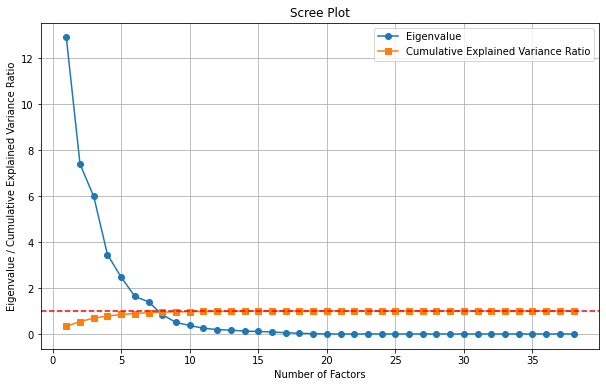

数据的自动选择的因子个数为7个。


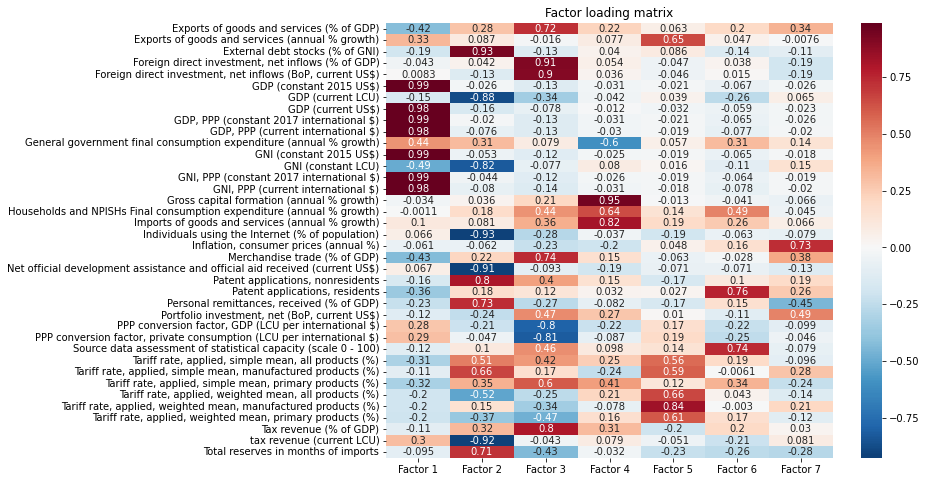

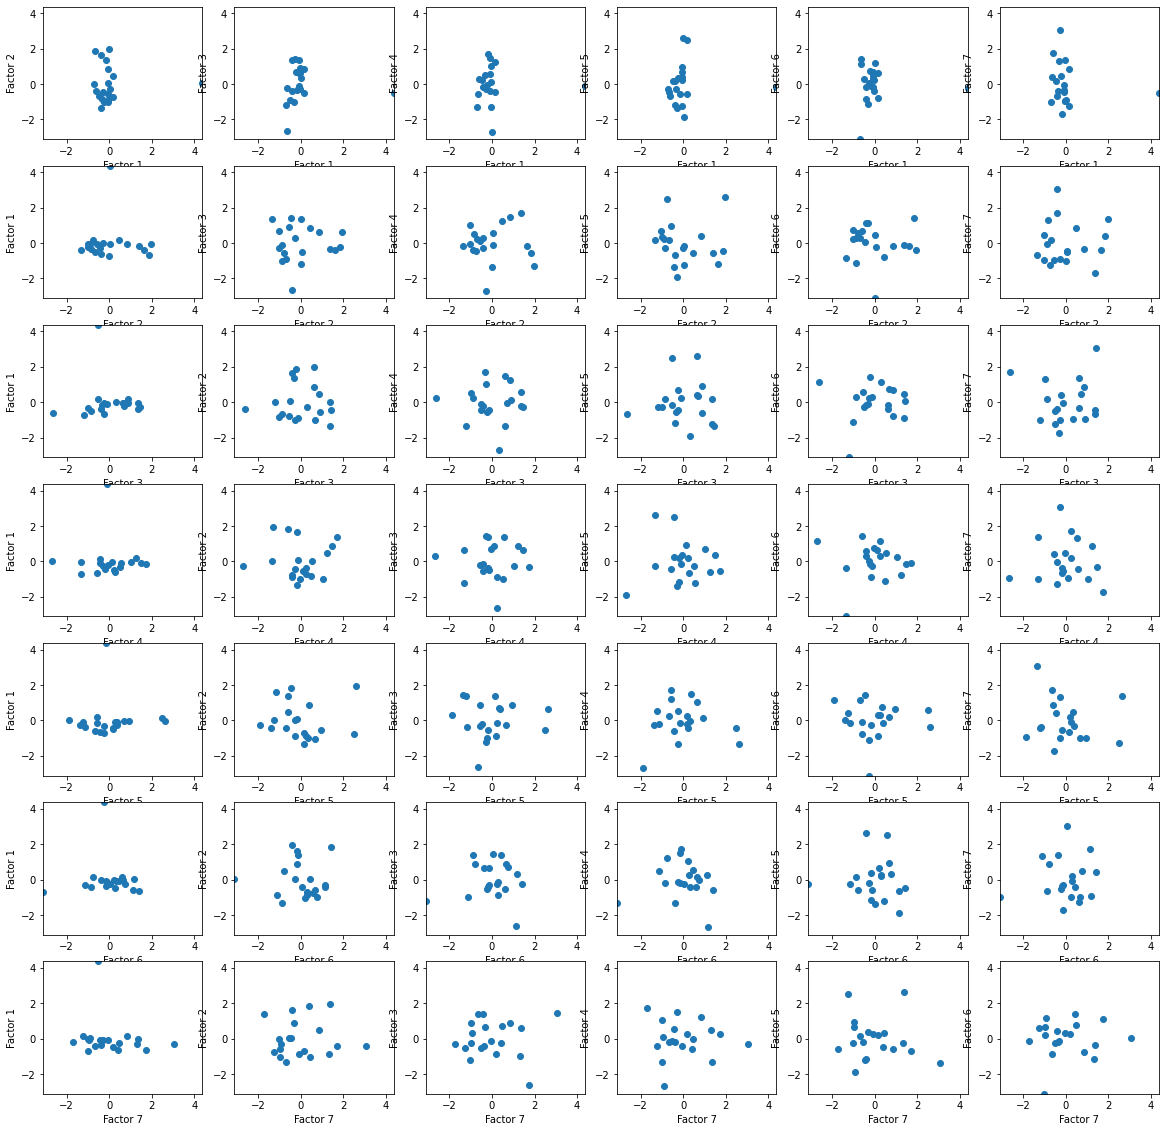

In [ ]:
factor_analysis(grouped_dfs['目标十七-38']['Norway'])

拆表

In [ ]:
# 遍历每个 DataFrame，按照国家分组并将每个分组存储在单独的 DataFrame 中
grouped_dfs = {}

# 定义一个空列表，用于存储出现错误的 DataFrame 名称
error_dfs = []

for sheet_name, df in dfs.items():
    grouped_dfs[sheet_name] = {}
    # 按照国家分组
    grouped = df.groupby('Country Name')
    
    # 遍历每个分组，将其存储在单独的 DataFrame 中
    for name, group in grouped:
        grouped_dfs[sheet_name][name] = group
        print(f'{sheet_name} 中的 {name} 数据已存储在名为“grouped_dfs[{repr(sheet_name)}][{repr(name)}]”的 DataFrame 中。')

总表格 中的 Argentina 数据已存储在名为“grouped_dfs['总表格']['Argentina']”的 DataFrame 中。
总表格 中的 Australia 数据已存储在名为“grouped_dfs['总表格']['Australia']”的 DataFrame 中。
总表格 中的 Brazil 数据已存储在名为“grouped_dfs['总表格']['Brazil']”的 DataFrame 中。
总表格 中的 Canada 数据已存储在名为“grouped_dfs['总表格']['Canada']”的 DataFrame 中。
总表格 中的 China 数据已存储在名为“grouped_dfs['总表格']['China']”的 DataFrame 中。
总表格 中的 Congo, Dem. Rep. 数据已存储在名为“grouped_dfs['总表格']['Congo, Dem. Rep.']”的 DataFrame 中。
总表格 中的 Costa Rica 数据已存储在名为“grouped_dfs['总表格']['Costa Rica']”的 DataFrame 中。
总表格 中的 Cuba 数据已存储在名为“grouped_dfs['总表格']['Cuba']”的 DataFrame 中。
总表格 中的 Czech Republic 数据已存储在名为“grouped_dfs['总表格']['Czech Republic']”的 DataFrame 中。
总表格 中的 Egypt, Arab Rep. 数据已存储在名为“grouped_dfs['总表格']['Egypt, Arab Rep.']”的 DataFrame 中。
总表格 中的 Equatorial Guinea 数据已存储在名为“grouped_dfs['总表格']['Equatorial Guinea']”的 DataFrame 中。
总表格 中的 Estonia 数据已存储在名为“grouped_dfs['总表格']['Estonia']”的 DataFrame 中。
总表格 中的 Fiji 数据已存储在名为“grouped_dfs['总表格']['Fiji']”的 DataFrame 中。
总表格 中的 Indonesia 数据已存储在名为“grouped_dfs['

In [ ]:
df = grouped_dfs['总表格']['Argentina']

# 创建新的 DataFrame，并从输入 DataFrame 复制
df_new = df.copy()

# 删除 Country Name 列
df_new.drop('Country Name', axis=1, inplace=True)

# 转置 DataFrame
df_new = df_new.set_index('Series Name').T
df_new = df_new.astype(float)

# 只选择数值型变量
df_num = df_new.select_dtypes(include=[np.number])

# 在选择数值列后检查 DataFrame 是否为空
if df_num.empty:
    print('输入的 DataFrame 不包含数值列，无法进行因子分析。')

# 检查数据是否包含至少两个不同的值
if df_num.nunique().min() < 2:
    print('数据中包含单一值或缺失值，无法进行因子分析。')


数据中包含单一值或缺失值，无法进行因子分析。
